<a href="https://colab.research.google.com/github/mattjperez/hands-on-ml/blob/master/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with MNIST

## Load MNIST dataset from sklearn's database

In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

##Preview and get to know the data




In [0]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [0]:
X, y = mnist['data'], mnist['target']

In [0]:
X.shape  #70,000 images, 28x28 pixels (784 pixels total)

(70000, 784)

In [0]:
y.shape  # Single Label per observation (i.e., 8, 0, 3, etc)

(70000,)

In [0]:
!pip install matplotlib

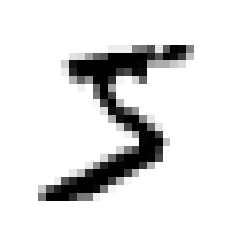

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Reshape the feature sets into their original 28x28 format
# "View" the image using a binary mapping of the reformatted observation

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [0]:
# As the label is a string, need to reformat to an integer
import numpy as np

y = y.astype(np.uint8)

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [0]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

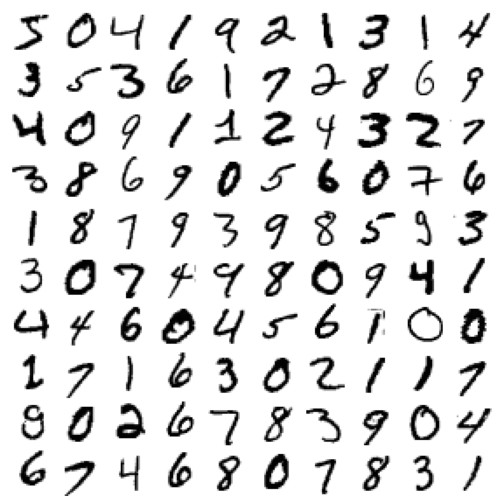

In [0]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [0]:
y[0]  # The label for the first observation is indeed 5

5

In [0]:
# Now that you know how the data set works, split the training and test sets

X_train, X_test, y_train, y_test = X[:60_000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier (True or False)

Start small, train a classifier to distinguish between what is 5 and what's not 5

In [0]:
y_train_5 = (y_train == 5)  #True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Stochastic Gradient Descent handles large datasets efficiently, so we'll start with that. 

Since it's stochastic, you can set a seed.

**Note:** The author book doesn't include the max_iter and tol parameters. Needed to look in author's github.

In [0]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)  # max_iter, tol weren't in book code
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
sgd_clf.predict([some_digit])

array([ True])

##Performance Measures

###Measuring Accuracy with Cross-Validation

#### Built-in Cross-Validation

In [0]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Pay attention to the 95% accuracy in the above cross-validation. Always get suspicious with that kind of result on an initial pass. 

That was for checking if a digit is a 5. Let's see how it does at checking if things aren't 5's. 

#### Hand-Coded Cross-Validation

For those that may want to develop your own implementation of cross_val_score() for a tailored process.

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]
  
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [0]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [0]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

**RED FLAG** The classifier is accurate 90% of the time. Coincicentally /s, in our data set, 5's make up about 10% of all observations. If the classifier just says nothing is a 5, it'll always get 90% accuracy. 

Accuracy is generally not the preferred way to measure classifier performance, especially with a skewed dataset (in this case, 10% for one value, 90% for 
another)

### Confusion Matrices, Precision and Recall

A confusion matrix is a much better way to measure the performance of a classifier. It will show true positives, true negatives, false positives, and false negatives. 

Instead of right and wrong, it's more like 'how right?' or 'how wrong'.

**Note from Statquest** Using a confusion matrix is excellent to determine Type 1 and Type 2 Errors. What's more important for your use case? If it's detecting cancer, having some false positives is much more preferable to having false negatives. A false negative could prevent someone who needs medical attention from popping on the radar. 

In [0]:
# we need predictions to run through the confusion matrix

from sklearn.model_selection import cross_val_predict

# instead of returning evaluation scores, this returns predictions on each fold

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

What a perfect classifier's confusion matrix would look like (highly unlikely)

In [0]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precision** is the percent-accuracy of classifier.



```
Precision = True Positives / (True Positives + False Positives)
```
- Out of everything classified as Positive, how many were correctly classified
- When this classifier picks marbles from a bag that it thinks are green, how often is it correct?


**Recall** aka **Sensitivity** aka **True Positive Rate (TPR)** 



```
True Positives / (True Positives + False Negatives)
```

- Out of all the Actual Positives, how many were correctly classified?
- How good is this classifier at finding all of the green marbles in a bag?

In [0]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [0]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

When this classifier detects a 5, it **is right 83.7% of the time**.

This classifier only **detects 65.1% of the 5's** in the set. 

**F<sub>1</sub> Score** is the *harmonic mean* of precision and recall. 

Harmonic mean is a weighted mean, with more weight to low values.

This means the F<sub>1</sub> score will only be high if **both** precision and recall are high. 


```
F1 = 2 / ((1/precision) + (1/recall)) = 2 * ((precision * recall) / (precision+ recall))
```



In [0]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

**Note:** The F<sub>1</sub> metric favors similar scores (i.e., when precision is similar to sensitivity). This is not always desired, depending on the use case (like the cancer detection example).

**Note 2:** Precision and Sensitivity have a similar relationship to that of bias and variance, thus there's a similar trade-off. The Precision/Recall trade-off.

## Decision Threshold

For each instance/observation, a score is generated. If that score passes a certain threshold, it will be classified as A, otherwise it will be classified as B. 

Modifying this threshold will affect the Precision and Recall conversely. Lowering the threshold may allow you to classify more of Class A (Recall), but this will also increase the amount of B that is misclassified as A, lowering your Precision. 

You can't set the threshold directly, but you can access the decision scores it uses for its predictions. Instead of **predict()**, you can use **decision_function()** to see the score for each instance. You can adjust the threshold using these scores as a reference. 

In [0]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [0]:
threshold = 0  # everything will pass the threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [0]:
threshold = 8000  # many things won't pass the threshold
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### Optimal Threshold

First, you need predictions to work with. More specifically, you need the decision scores of these predictions. This can be done using a parameter in cross_val_predict().

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Using these scores, you can iterate through different thresholds and find their corresponding precision-recall scores at diffent threshold values. 

In [0]:
# Compute precision-recall scores for all possible thresholds

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


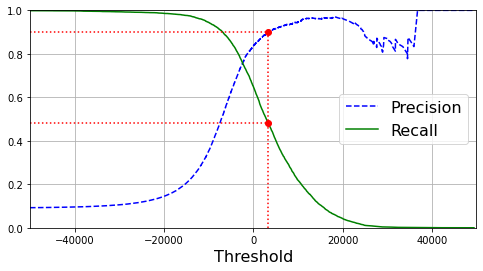

In [0]:
# Plot precision and recall as a function of threshold value

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
  plt.legend(loc="center right", fontsize=16) # Not shown in the book
  plt.xlabel("Threshold", fontsize=16)        # Not shown
  plt.grid(True)                              # Not shown
  plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

The red dots show where 90% precision and its corresponding recall value. 
The upper red-dotted area shows the range you can play with to find your ideal trade-off.

**Note:** Precision can get bumpy because the score is relative to targets and non-targets above the threshold at a given time whereas recall can only go down as the threshold increases, appearing smooth.  

In [0]:
(y_train_pred == (y_scores > 0)).all()

True

### Direct Precision-to-Recall Plot

Precision and Recall can be plotted against eachother and you can make a visual 
judgement on how to maximize the trade-off. 

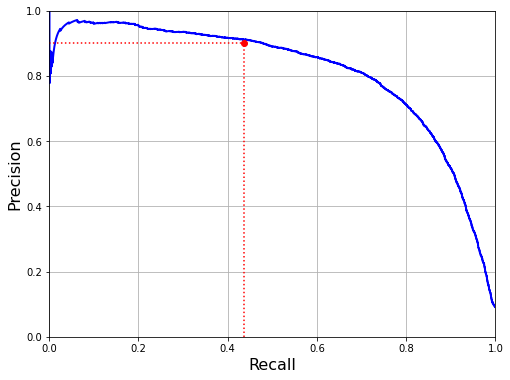

In [0]:
# Code wasn't shown in book

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

You can use the desired precision to reference the first plot and find an approximate threshold. Alternatively, you can use numpy's argmax function to find the first threshold value that will fulfill the desired condition


```
precision >=0.90
```



In [0]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

We can see what the actual precision and recall are at the specified threshold.

In [0]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [0]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Therefore, with a threshold of 3370:
- When the classifier detects a 5, 90% of the time, it is correct.
- The classifier will detect ~48% of all the 5s.

The book says a high-precision classifier is not very useful if its recall is too low. What about for investments? Trying to catch every unicorn would be insane. With investing, not losing money is more important than making money. This seems like a possible approach for that. 

## ROC and AUC

The **Receiver Operating Characteristic** (ROC). 

The name comes from its roots in WWII, used to measure a radar's performance at detecting enemy aircraft. 

ROC curve plots True Positive Rate (Recall) against False Positive Rate

False Positive Rate = 1 - True Negative Rate (aka specificity)

The thresholds variable will store the thresholds that gives the corresponding FPR and TPR.


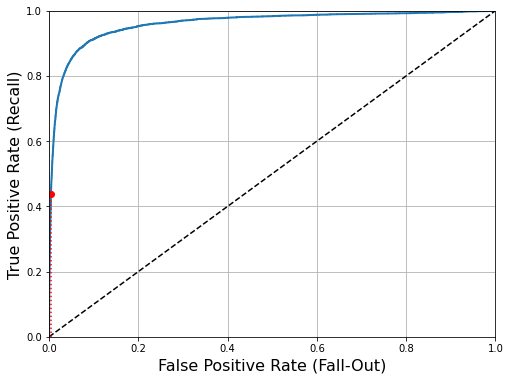

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
  plt.axis([0, 1, 0, 1])                                    # Not shown in the book
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
  plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

The higher the Recall, the more False Positives you'll get. 

**Note:** The dotted line is the ROC of a purely random classifier (50/50, like flipping a coin). The better the classifier, the more to the top left the curve will be. 

The **Area Under Curve** (AUC) is exactly as it sounds. 

It's the percent of that plot that falls under the curve as a percentage. A perfect classifier will have an AUC of 1.0 and a random classifier would be about 0.5 (area of graph under the dotted line).

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Note:** You should prefer the Precision-Recall Curve over ROC when:
- the number of Positives is rare (fraudulant charges vs real charges)
- you are concerned about False Positives more than False Negatives

Otherwise, use ROC/AUC.

This scenario was an example of the first bullet point. By looking at the PR Curve, you can see there's still a lot of room for improvement while the ROC/AUC says it's doing really well. 

### A Random Forest ROC/AUC vs an SGD's 

Generate predictions to be used for the confusion matrix, PR, and ROC.

Random Forests don't use decision_function(). Instead they use predict_proba().
This shows the probability an observation is one class or another.

**Note:** Scikit-Learn classifiers usually have one of these methods, but sometimes have both.

In [0]:
# Generate predictions using Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                    cv=3, method='predict_proba')

In [0]:
# Use the predictions to find the FPR and TPR at different thresholds

y_scores_forest = y_probas_forest[:, 1]  # All rows, column 1 (Probability is Positive)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

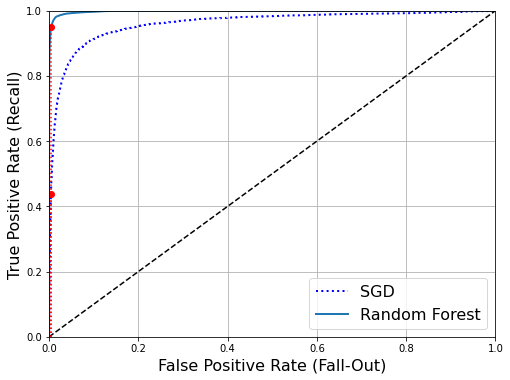

In [0]:
# Plot the ROC Curve of SGD and RandomForest on the same graph for comparison


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

**Note:** Call the main plot function last.

The graph shows the Random Forest performing much better than SGD. 
We can find the AUC for the actual difference.

In [0]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

ROC/AUC
- SGD: 96%
- RFC: 99.8%
- Delta: 3.8%

In [0]:
# Convert RFC's probabilities to 1s and 0s
y_scores_forest_int = np.round(y_scores_forest).astype(int)

precision_score(y_train_5, y_scores_forest_int)

0.9905083315756169

In [0]:
recall_score(y_train_5, y_scores_forest_int)

0.8662608374838591

Precision
- SGD: 83.7%
- RFC: 99.0%
- Delta: ~16%

Recall
- SGD: 65.1%
- RFC: 86.6%
- Delta: ~21%

## Multiclass Classification

Binary Classifiers distinguish between two classes. Multiclass Classifiers (aka multinomial classifiers) distinguish between multiple classes.

>Binary Classifiers:
- Support Vector Machines
- Stochastic Gradient Descent

>Multiclass Classifiers:
- Logistic Regression (changed from default binary recently)
- Random Forest
- Naive Bayes

Binary classifiers can be used for multiclass purposes, but it needs one classifier per label. The classifier with the highest decision score determines the final prediction. This is called one-versus-the-rest (OvR) or one-versus-all. 

**Note** Sounds like a Neural Network

Another strategy is one-versus-one (OvO), that has as many classifiers as there are pair combinations. 

```
C(10, 2) = 45 combinations = 45 classifiers
```
The main advantage is that each classifier only needs to train on a subset of the data. 

**Note:** SVM scales poorly depending on the size of the training set, so this approach is preferred. Most binary classifiers work better with OvR though.

**Note 2:** Scikit-learn can tell if you use a binary classifier for multiclass purposes. It'll automatically use OvR or OvO depending on classifier's defaults.
 

**Note:** In book, author stated SGD handles multiclass directly, but according to documentation SGD does use binary classfication methods; One-vs-all specifically. Author confirms in O'Reilly Errata.

### Multiclass SVM (default= OvO)

In [0]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto', random_state=42)  
svm_clf.fit(X_train[:1000], y_train[:1000])  # full y_train, not y_train_5, index wasn't in book
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, SVM created 45 binary classifiers which gave each observation an array of 10 decision scores, one for each possible label.

In [0]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [0]:
# Target classes stored in .classes_ ordered by value, 
# Luckily our labels match their indices

svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [0]:
# When using non-numerical numers, can verify the label of a specific index

svm_clf.classes_[5]  #index, returns label

5

In [0]:
# Prediction can also be seen using the argmax function

np.argmax(some_digit_scores)

5

### Multiclass SVM (OvR)

To force a binary classifier to use another approach, use one of the following classes:
- OneVsOneClassifier()
- OneVsRestClassifier()

**Warning** The next code block takes about 60min on Google colab, 5min on ColabPro D:

In [0]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [0]:
# Number of binary classifiers made

len(ovr_clf.estimators_)


10

In [0]:
ovr_clf.decision_function([some_digit])

array([[-0.9990256 , -0.99963766, -0.99949709, -0.99902667, -0.99986906,
         0.10132159, -0.99976287, -0.99933311, -0.99943631, -0.99924045]])

### Multiclass Classifier

In [0]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

In [0]:
# Decision scores assigned to each class

sgd_clf.decision_function([some_digit])


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**SGD RETURNING DIFFERENT VALUES, OPEN ISSUE ON REPO**

The classifier is very confident about its prediction, only one other label having a positive score, and it's one-fifth that of the correct label. This means there is model feels there's a slight possibility the label is a 3 instead of a 5. Like doubt. 

In [0]:
# checking SGD's accuracy

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

It does well at around 86%, but let's try preprocessing the inputs using a standard scaler. 

**Note:** This is a common preprocessing technique done to images before being used in a convolutional neural network.

**Note 2:** The reason this works better is because a zero-centered unit like a z-score is easier for the model to work with as opposed to a range of 0 to 255. 

Imagine if you had to repeatedly reference the mean and instead of an easy number like 0 you have to constantly compute it because it changes with every set, subset, or single observation. 

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

Scores much better. Always check what preprocessing techniques work well with your data's format and the chosen model. 

## Error Analysis

This next part is for after you've:
- explored the data
- try multiple models
- select candidate models
- and fine-tune the hyperparameters

This section is about analyzing the types of errors your model makes.

In [0]:
# Start with a confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


In [0]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

When the numbers are confusing, you can use matplotlib's matshow() function for a nice graphical representation.

In [0]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In this grayscale image, 5 is slightly darker than the rest. This can mean:
1. There are fewer images of 5s in the dataset
2. or the classifier doesn't do well with 5s

In [0]:
# divide matrix by number of observations per class for relative errors instead of absolute
# absolute errors make abundant classes look comparatively worse

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill diagonal with zeroes to focus on errors

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows represent actual class while columns represent predicted class.

Bright columns (predicted label) mean more misclassifications of that label. The brighter the box, the less precision (more false positives)

A dark row (actual label) means higher sensitivity to that label. 

This model seems to have a high sensitivity to 8s but lower precision for 8s. 8s are usually classified correctly, but non-8s are often misclassified as 8s.

Ways you can **improve precision** on 8s:
- Use more training data that looks like 8s but aren't.
- Engineer new features to help the classifier (like counting loops)
- Preprocess the image to make loops stand out more (Scikit-Image, Pillow, OpenCV).

**Analyzing individual errors** are a great way to get an idea of what's going wrong, but can difficult and time-consuming. 

The 3s and 5s seem to be misclassified as eachother often. Let's take a look at the actual images.

In [0]:

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The 5x5 blocks on the left are classified as 3s by the model.

The 5x5 blocks on the right are classified as 5s.

The linear classifier used (SGD) uses the weights of the pixels which it then sums up. Since 3s and 5s differ by only a few pixels, their sums are similar and easily confused for one another. 

The main difference between 3 and 5 is the joint that connects the top of the number to the bottom. If the joint is to the left of center it might classify a 5; a 3 if it's right of center. This means the **this classifier is sensitive to image shifting and rotation**. Try preprocessing the images to ensure centeredness and minimal rotation to help reduce errors. 

## Multilabel Classification

In [0]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

The np.c_ concats column-wise (adding the array/matrix to the right), np.r_ would concat row-wise (adding the array/matrix to the bottom). 

Like stacking matrices (np.r_) vs augmenting a matrix (np.c_)

**Note:** This method reminds me of OneHotEncoding

In [0]:
# Predicts if Large[0] and/or Odd[1]

knn_clf.predict([some_digit])

One approach to evaluating a multilabel classifier is calculating the F<sub>1</sub> score of each label, then compute the average. The next code computes the average F<sub>1</sub> score across all labels.

In [0]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

This method assumes all labels are equally important, but that may not be the case if one label is more prominant overall than others. One method is to give each label a weight equal to its support (number of instances with that target label). To do that, just change 'macro' from the code above to 'weighted'. 

##Multioutput Classification

Multioutput-Multiclass Classification (or just Multioutput Classification). Each label can have multiple classes.

The example in the book reduces noise from an image (looks like static). The labels are:
1. label per pixel
2. intensity of the pixel (0-255)

In [0]:
# create training set by adding noise to MNIST images via randint

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [0]:
# checking out the result on a test image (which is bad practice)

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [0]:
# training the classifier to clean the image

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Exercises

## 1) MNIST Classifier w/ Accuracy >97%

In [0]:
# This cell will take hours if you run it. 

from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid+search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

SyntaxError: ignored

In [0]:
grid_search.best_params_

In [0]:
grid_search.best_score_

In [0]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

## Data Augmentation

### Choosing Augments

In [0]:
from scipy.ndimage.interpolation import shift

In [0]:
def shift_image(image, dx, dy):
  image = image.reshape((28, 28))
  shifted_image = shift(image, [dx, dy], cval=0, mode='constant')
  return shifted_image.reshape([-1])

In [0]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28,28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

NameError: ignored

### Augmenting the dataset

In [0]:
#copies original dataset
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

# Adds right-shifted, left-shifted, and down-shifted versions to dataset
for dx, dy in ((1,0), (-1,0), (0,-1)):
  for image, label in zip(X_train, y_train):
    X_train_augmented.append(shift_image(image,dx,dy))
    y_train_augmented.append(label)  # 3 new images, same label

# convert lists to numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [0]:
# reshuffle dataset

shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [0]:
# knn classifier using params found in exercise 1

knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [0]:
# fit classifier onto augmented-shuffled dataset
knn_clf.fit(X_train_augmented, y_train_augmented)

In [0]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

## Titanic

### Import and Preview Dataset

In [0]:
import os

# make path to directory with dataset
TITANIC_PATH = os.path.join("storage", "data", "titanic")

In [0]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
  csv_path = os.path.join(titanic_path, filename)
  return pd.read_csv(csv_path)

In [0]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [0]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [0]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [0]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [0]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [0]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [0]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Build Preprocessing Pipelines

This selector allows sklearn's built-in fit and transform functions to be applied to a class.

Must not use \*args or \**kwargs parameters to activate these functions.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Build Pipelines for Numerical Attributes

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median")),
])

In [0]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

Build Pipelines for Categorical Attributes

In [0]:
# create custom imputer class for categorical attributes

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),  # for missing values
    ("cat_encoder", OneHotEncoder(sparse=False)),  # to encode nominal values
])

In [0]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [0]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion([
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [0]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [0]:
y_train = train_data["Survived"]

In [0]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [0]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

In [0]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

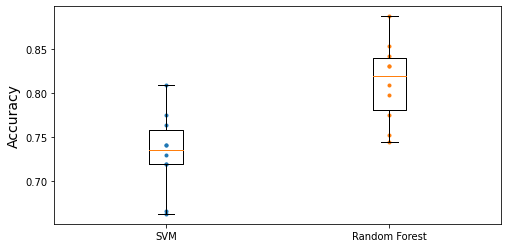

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [0]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [0]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## Spam Classifier

In [0]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("storage", "data", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [0]:
fetch_spam_data()

In [0]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [0]:
len(ham_filenames)

2500

In [0]:
len(spam_filenames)

500

In [0]:
import email
import email.policy

def load_emails(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [0]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_emails(is_spam=True, filename=name) for name in spam_filenames]

In [0]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [0]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [0]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(",".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [0]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [0]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain,application/pgp-signature)', 66),
 ('multipart(text/plain,text/html)', 8),
 ('multipart(text/plain,text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain,application/octet-stream)', 2),
 ('multipart(text/plain,text/enriched)', 1),
 ('multipart(text/plain,application/ms-tnef,text/plain)', 1),
 ('multipart(multipart(text/plain,text/plain,text/plain),application/pgp-signature)',
  1),
 ('multipart(text/plain,video/mng)', 1),
 ('multipart(text/plain,multipart(text/plain))', 1),
 ('multipart(text/plain,application/x-pkcs7-signature)', 1),
 ('multipart(text/plain,multipart(text/plain,text/plain),text/rfc822-headers)',
  1),
 ('multipart(text/plain,multipart(text/plain,text/plain),multipart(multipart(text/plain,application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain,application/x-java-applet)', 1)]

In [0]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain,text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain,image/jpeg)', 3),
 ('multipart(text/html,application/octet-stream)', 2),
 ('multipart(text/plain,application/octet-stream)', 1),
 ('multipart(text/html,text/plain)', 1),
 ('multipart(multipart(text/html),application/octet-stream,image/jpeg)', 1),
 ('multipart(multipart(text/plain,text/html),image/gif)', 1),
 ('multipart/alternative', 1)]

In [0]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [0]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [0]:
html_spam_emails = [email for email in X_train[y_train==1]
                   if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [0]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [0]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [0]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [0]:
!pip3 install nltk

In [0]:
!pip install urlextract

In [0]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [0]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [0]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [0]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [0]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.longlong'>'
	with 20 stored elements in Compressed Sparse Row format>

In [0]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int64)

In [0]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [0]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

[CV]  ................................................................
[CV] .................................... , score=0.981, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.990, total=   0.1s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


0.9854166666666666

In [0]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 95.88%
Recall: 97.89%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
